# Mean Flow

TL;DR: This write-up contains the minimum essential concepts and simple code to understand [mean flow](https://arxiv.org/pdf/2505.13447).

Readers are assumed to be familiar with [flow matching](https://arxiv.org/pdf/2210.02747). Readers are strongly encouraged to read the blog on [rectified flow](https://github.com/wenhangao21/Concept2Code-papers-in-30-minutes/blob/main/rectified_flow/Rectified_flow.ipynb) as well.

The code is based on the authors' pytorch implementation provided in [this repo](https://github.com/Gsunshine/py-meanflow).


If you have any questions or notice any errors, please contact [Wenhan Gao](https://wenhangao21.github.io/).

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
device = 'cpu' # change to cpu if no cuda available
batch_size = 2048
iterations = 10_000
wd = 0.01 # weight decay

## Background and Notations

We are given two distributions $\pi_0$ and $\pi_1$, we aim to find a transport map $T$ such that, when $Z_0 \sim \pi_0$, then $Z_1 = T(Z_0) \sim \pi_1$.

- $\pi_0$ is the source distribution, and $\pi_1$ is the target distribution.

Let's define two distributions.

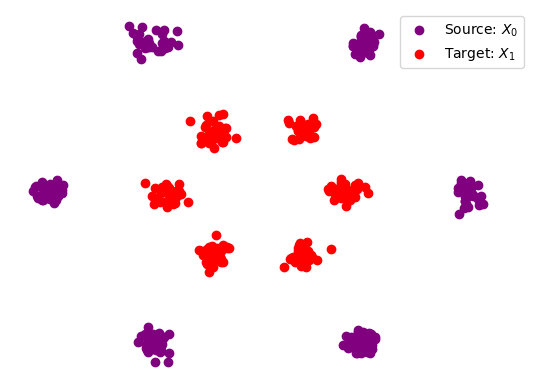

In [2]:
def sample_multimodal_gaussian(modes, std, N=1000):
    """
    Generates samples from a multimodal distribution defined by the given modes.

    Each sample is generated by:
      1. Selecting a mode at random from the provided list of modes.
      2. Creating a random sample from a standard normal distribution (Gaussian noise).
      3. Offsetting the first two dimensions of the sample by the selected mode's coordinates.

    Parameters:
        modes (np.ndarray): An array of shape (n_modes, D) where each row defines the coordinates of a mode (cluster center).
        std (float): Standard deviation of the Gaussian noise added to each sample.
        N (int, optional): Number of samples to generate. Default is 1000.

    Returns:
        np.ndarray: A (N, D)-shaped array of samples.
    """
    dataset = []
    for i in range(N):
        sample = np.random.randn(modes.shape[1]) * std
        mode_idx = np.random.randint(modes.shape[0])
        sample[0] += modes[mode_idx, 0]
        sample[1] += modes[mode_idx, 1]
        dataset.append(sample)
    return np.array(dataset, dtype="float32")

def sample_pi(radius, N=1000):
  # The modes are six equidistant points on a circle of radius r.
  theta = np.array([0., 60, 120, 180, 240,  300]) / 360 * 2 * np.pi
  std = 0.5
  modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta), np.sin(theta))])
  pi = sample_multimodal_gaussian(modes, std, N=N)
  return pi

def sample_pi_0(N=1000):
  return sample_pi(radius=12, N=N)

def sample_pi_1(N=1000):
  return sample_pi(radius=5, N=N)

# Visualize these two distributions
pi_0 = sample_pi_0(N=10_000)
pi_1 = sample_pi_1(N=10_000)
plt.figure()
plt.scatter(pi_0[::50, 0], pi_0[::50, 1], c='purple', label=r'Source: $X_0$')
plt.scatter(pi_1[::50, 0], pi_1[::50, 1], c='red', label=r'Target: $X_1$')
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
plt.axis('off')
plt.gca().set_frame_on(False)
plt.show()

The mapping $T$ is implicitly defined by an ordinary differential equation (ODE):

$$
\frac{d}{d t} Z_t=v\left(Z_t, t\right), \quad Z_0 \sim \pi_0, \quad \forall t \in[0,1],
$$
where $v\left(Z_t, t\right)$ is called the velocity field.

There are infinitely many ways to define the vector field $v\left(Z_t, t\right)$. We choose the linear interpolant, in both time and space, due to its simplicity. That is:

Assume we observe $X_0 \sim \pi_0$ and $X_1 \sim \pi_1$. Let $X_t$ for $\forall t \in[0,1]$ be the linear interpolation of $X_0$ and $X_1$:
$$
X_t=t X_1+(1-t) X_0, \quad t \in[0,1].
$$
Taking derivatives with respect to $t$, we have an "ODE":
$$
\frac{d}{d t} X_t=X_1-X_0, \quad \forall t \in[0,1] .
$$
We parametrize $v$ with a neural network and train it to match the conditional velocity given the end points, i.e. $X_1-X_0$ with the following training objective:

$$
\min _v \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1, t\sim \text{Uniform}(0,1)}\left[\left\|\left(X_1-X_0\right)-v\left(X_t, t\right)\right\|^2\right].
$$

## Learned Flow Model: Curved trajectories

Let's train a flow model.

In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim, time_dim, h, out_dim):
        super(MLP, self).__init__()
        self.network = nn.Sequential(nn.Linear(in_dim + time_dim, h), nn.Tanh(),
                                     nn.Linear(h, h), nn.Tanh(),
                                     nn.Linear(h, out_dim))

    def forward(self, x, t):
        return self.network(torch.cat((x, t), dim=1))

def train_regular_flow(flow_model, optimizer, iterations, eps=1e-15):
    """
    Trains a flow model to learn velocity fields between point pairs.

    For each batch, the function:
    - Randomly samples observations from pi_0 and pi_1, respectively and an interpolation time t ∈ [0, 1]
    - Computes the interpolated point x_t = (1 - t) * x0 + t * x1
    - Trains the model to predict the volecity (x1 - x0) at x_t and time t

    Args:
        flow_model (nn.Module): The neural network model representing the velocity field.
        optimizer (torch.optim.Optimizer): Optimizer used for training.
        epochs (int): Number of training iterations.
    """
    losses = []
    progress_bar = tqdm(range(iterations), desc="Training Mean Flow", ncols=100)
    for iteration in progress_bar:
        x1 = torch.from_numpy(sample_pi_1(N=batch_size)).to(device)
        x0 = torch.from_numpy(sample_pi_0(N=batch_size)).to(device)
        tr = torch.rand((x1.shape[0], 2), device=device)
        t = torch.rand((x1.shape[0], 1), device=device) # randomly sample t
        x_t = t * x1 + (1.-t) * x0
        target = x1 - x0
        pred = flow_model(x_t, t)
        loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        progress_bar.set_postfix({"loss": f"{loss.item():.6f}"})

regular_flow = MLP(2, 1, 64, 2).to(device)
optimizer = torch.optim.Adam(regular_flow.parameters(), lr=5e-3, weight_decay=wd)
training_loss = train_regular_flow(regular_flow, optimizer, iterations, eps=1e-15)
torch.save(regular_flow.state_dict(), 'regular_flow.pth')

Training Mean Flow: 100%|█████████████████████| 10000/10000 [08:51<00:00, 18.83it/s, loss=34.283524]


In [4]:
# regular_flow.load_state_dict(torch.load('regular_flow.pth'))

Let's sample from $\pi_1$ with the flow model and visualize some of the trajectories.

100%|██████████| 1000/1000 [00:13<00:00, 76.64it/s]


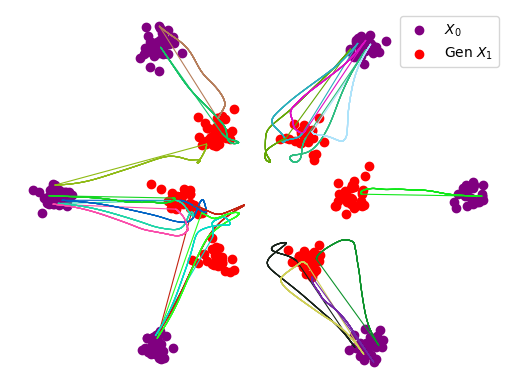

In [5]:
def sample_regular_flow(flow_model, T, pi_0):
    """
    Simulates the forward flow trajectory starting from pi_0 using the learned velocity field.

    This function performs forward Euler over T discrete time steps to generate the trajectory
    of each point in pi_0 according to the velocity predicted by the regular_flow model.

    Args:
        flow_model (nn.Module): The trained regular flow model that predicts velocity vectors.
        T (int): Number of time steps for forward Euler.
        pi_0 (torch.Tensor): Initial samples.

    Returns:
        torch.Tensor: A tensor of shape containing the full trajectory with T+1 steps for each point over time.
    """
    samples = [pi_0.clone().unsqueeze(0)]
    for i in (range(T)):
        t = torch.ones((pi_0.shape[0], 1), device=samples[-1].device) * i / T
        drift_pred = flow_model(samples[-1].squeeze(0), t)
        samples.append((samples[-1] + drift_pred * 1. / T)) # intermedia Z_t stored for visualization purposes
    return torch.cat(samples)

def visualize_regular_flow_sampling(flow_model, T=1000):
    """
    Visualizes the sampling trajectory of the flow model.

    This function:
    - Samples X_0.
    - Evolves these points forward using the flow model over 1000 steps.
    - Plots X_0, generated X_1, and a subset of intermediate trajectories.

    Args:
        flow_model (nn.Module): A trained flow model used to simulate particle movement.
    """
    test_pi_0 = sample_pi_0(N=200)
    test_pi_1 = sample_regular_flow(flow_model=flow_model, T=T, pi_0=torch.from_numpy(test_pi_0).to(device))
    plt.figure()
    plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], c='purple', label=r'$X_0$')
    plt.scatter(test_pi_1[-1, :, 0].data.cpu().numpy(),
                test_pi_1[-1, :, 1].data.cpu().numpy(), c='red', label=r'Gen $X_1$')
    num_trajs = test_pi_0.shape[0] // 10  # Number of trajectories to plot
    colors = [np.random.rand(3,) for _ in range(num_trajs)]  # One color per trajectory

    for i in tqdm(range(0, T)):
        for k, j in enumerate(range(0, test_pi_0.shape[0], 10)):
            plt.plot(
                [test_pi_1[i-1, j, 0].item(), test_pi_1[i, j, 0].item()],
                [test_pi_1[i-1, j, 1].item(), test_pi_1[i, j, 1].item()],
                linewidth=0.8,
                color=colors[k]
            )
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.gca().set_frame_on(False)
    plt.show()

visualize_regular_flow_sampling(regular_flow)

## Mean Flow: One-step Generation

As shown above, the trajectories are curved. The generative process computed by numerical solvers (forward Euler in this case) requires extensive amount of steps to ensure numerical precision.

Mean flow mitigates this issue by learning the **average velocity** over intervals **instead of the instantaneous velocity** $v\left(Z_t, t\right)$.

The average velocity $u\left(Z_t, r, t\right)$ over an interval $[r, t]$ with $t > r$ is defined as:
$$
u(Z_t, r, t) \triangleq \frac{1}{t - r} \int_{r}^{t} v(Z_s, s) ds.
$$
The goal is to train a neural network $u_\theta(X_t, t, r)$ to approximate $u$. With a good approximation, **we can approximate the entire flow path using a single evaluation of $u_\theta(X_0, 0,1)$ (one-step generation)**.

Note that we do not have $\int_{r}^{t} v(Z_s, s) ds$ for training, so we manipulate this formulation a little:


\begin{align*}
u(Z_t, r, t)
    &= \frac{1}{t - r} \int_{r}^{t} v(Z_s, s)\, ds \\
(t - r)\, u(Z_t, r, t)
    &= \int_{r}^{t} v(Z_s, s)\, ds \\
\frac{d}{dt}\!\big[(t - r)\, u(Z_t, r, t)\big]
    &= \frac{d}{dt} \int_{r}^{t} v(Z_s, s)\, ds \\
\underbrace{u(Z_t, r, t) + (t-r) \frac{d}{dt} u(Z_t, r, t)}_{\text{By chain rule}}
    &= \underbrace{v(Z_t, t)}_{\text{By fundamental theorem of calculus}}\\
\underbrace{u(Z_t, r, t)}_{\text{avg. vel.}}
    &= \underbrace{v(Z_t, t)}_{\text{instant. vel.}}
       -
       (t - r) \underbrace{\frac{d}{dt} u(Z_t, r, t)}_{\text{time derivative}}.
\end{align*}
**Note that autograd can only directly compute explicit (partial) derivatives, while the time derivative is implicit ($u$ is a functional of a function of $t$).** We apply multivariate chain rule:

$$\frac{d}{d t} u\left(Z_t, r, t\right)=\frac{d Z_t}{d t} \frac{\partial u}{\partial Z_t}+\frac{d r}{d t}  \frac{\partial u}{\partial r}+\frac{d t}{d t}  \frac{\partial u}{\partial t},$$
where $\frac{d Z_t}{d t} = v, \frac{d t}{d t} = 1$ and $\frac{d r}{d t} = 0$. This equation shows that the total derivative is given by the Jacobian-vector product (JVP) between $\left[\frac{\partial u}{\partial Z_t}, \frac{\partial u}{\partial r}, \frac{\partial u}{\partial t}\right]$ (the Jacobian matrix of the function $u$ ) and the tangent vector $[v, 0,1]$. It can be efficiently computed by `torch.func.jvp` in PyTorch.

During training, as in linear interpolant flow matching, we sample $X_0$ and $X_1$ and construct the interpolated $X_t$. We then replace $v$ with the conditional velocity given the end points: $\frac{d}{d t} X_t=X_1-X_0$.

Here, not to be confused, we use $X$ to denote real samples, while $Z$ just denotes the variable. The training objective is:

$$
\min _v \int_0^1 \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1, r, t}\left[\left\| u_\theta\left(X_t, r, t\right) - \left(\left(X_1-X_0\right) - (t-r) \left[\frac{\partial u}{\partial X_t}, \frac{\partial u}{\partial r}, \frac{\partial u}{\partial t}\right] \cdot [v, 0,1] \right)\right\|^2\right] d t,
$$
where $r=\min \left(s_1, s_2\right), t=\max \left(s_1, s_2\right)$ with $s_1,s_2 \sim \text{Uniform (0,1)}$, and $X_t=t X_1+(1-t) X_0$.

Let's parameterize $u$ and optimize it.

In [13]:
# Mean flow takes another time r in addition to t
class MLP(nn.Module):
    def __init__(self, in_dim, context_dim, h, out_dim):
        super(MLP, self).__init__()
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h), nn.Tanh(),
                                     nn.Linear(h, h), nn.Tanh(),
                                     nn.Linear(h, out_dim))

    def forward(self, x, t, r):
        return self.network(torch.cat((x, t, r), dim=1))


def train_mean_flow(flow_model, optimizer, scheduler, iterations):
    """
    Trains a mean flow model to learn average velocity fields between time points.

    For each batch, the function:
    - Randomly samples two time points t and r ∈ [0, 1], t>r
    - Computes the interpolated point x_t = (1 - t) * x0 + t * x1
    - Trains the model to predict the average volecity by the loss shown above

    Args:
        flow_model (nn.Module): The neural network model representing the mean velocity.
        optimizer (torch.optim.Optimizer): Optimizer used for training.
        iterations (int): Number of training iterations.
    """
    flow_model.train()
    losses = []
    progress_bar = tqdm(range(iterations), desc="Training Mean Flow", ncols=100)
    for iteration in progress_bar:
        x1 = torch.from_numpy(sample_pi_1(N=batch_size)).to(device)
        x0 = torch.from_numpy(sample_pi_0(N=batch_size)).to(device)
        tr = torch.rand((x1.shape[0], 2), device=device)
        t = tr.max(dim=1, keepdim=True).values
        r = tr.min(dim=1, keepdim=True).values
        x_t = t * x1 + (1.-t) * x0
        v = x1 - x0   # conditional velocity given the end points
        dtdt, drdt = torch.ones_like(t), torch.zeros_like(r)
        u_pred, dudt = torch.func.jvp(flow_model, (x_t, t, r), (v, dtdt, drdt))
        u_target = (v - (t - r) * dudt).detach()
        loss = (u_pred - u_target).abs().pow(2).sum(dim=1).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        progress_bar.set_postfix({"loss": f"{loss.item():.6f}"})

mean_flow = MLP(2, 2, 64, 2).to(device)
# Mean flow is harder to train.
optimizer = torch.optim.AdamW(mean_flow.parameters(), lr=5e-4, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)
training_loss = train_mean_flow(mean_flow, optimizer, scheduler, iterations)
torch.save(mean_flow.state_dict(), 'mean_flow.pth')

Training Mean Flow: 100%|███████████████████| 10000/10000 [09:53<00:00, 16.84it/s, loss=1008.120056]


Once the velocity field $v_\theta\left(Z_t, t\right)$ is learned, we can simulate samples from $\pi_1$ given samples from $\pi_0$ by solving the forward ODE by performing the time integral with mean velocity:
$$Z_t=Z_r+(t-r) u_\theta\left(Z_r, r, t\right).$$
One step generation can be achieved by:
$$Z_t=Z_0+ u_\theta\left(Z_r, 0, 1\right).$$

Let's sample from $\pi_1$, visualize some of the trajectories with different total time steps.

1000 steps:

In [7]:
def sample_mean_flow(flow_model, T, pi_0):
    """
    Simulates the forward flow trajectory starting from pi_0 using the learned mean velocity.

    This function performs time integral over T discrete uniform time steps to generate the trajectory
    of each point in pi_0 according to the mean flow predicted by the mean_flow model.

    Note that the mean flow does not require uniform time steps; any sequence from 0 to 1 suffices.
    We use uniform time steps here for simplicity.

    Args:
        flow_model (nn.Module): The trained mean flow model that predicts mean velocity.
        T (int): Number of time steps for time integral.
        pi_0 (torch.Tensor): Initial samples.

    Returns:
        torch.Tensor: A tensor of shape containing the full trajectory with T+1 steps for each point over time.
    """
    samples = [pi_0.clone().unsqueeze(0)]
    dt = 1./T
    for i in (range(T)):
        t = torch.ones((pi_0.shape[0], 1), device=samples[-1].device) * (1 - i * dt)
        r = t - dt
        v_pred = flow_model(samples[-1].squeeze(0), t, r)
        samples.append((samples[-1] + v_pred * 1. / T)) # intermedia Z_t stored for visualization purposes
    return torch.cat(samples)

def visualize_mean_flow_sampling(flow_model, T):
    """
    Visualizes the sampling trajectory of the flow model.

    This function:
    - Samples X_0.
    - Evolves these points forward using the flow model over 1000 steps.
    - Plots X_0, generated X_1, and a subset of intermediate trajectories.

    Args:
        flow_model (nn.Module): A trained flow model used to simulate particle movement.
    """
    test_pi_0 = sample_pi_0(N=200)
    test_pi_1 = sample_mean_flow(flow_model=flow_model, T=T, pi_0=torch.from_numpy(test_pi_0).to(device))
    plt.figure()
    plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], c='purple', label=r'$X_0$')
    plt.scatter(test_pi_1[-1, :, 0].data.cpu().numpy(),
                test_pi_1[-1, :, 1].data.cpu().numpy(), c='red', label=r'Gen $X_1$')
    num_trajs = test_pi_0.shape[0] // 10  # Number of trajectories to plot
    colors = [np.random.rand(3,) for _ in range(num_trajs)]  # One color per trajectory

    for i in tqdm(range(0, T)):
        for k, j in enumerate(range(0, test_pi_0.shape[0], 10)):
            plt.plot(
                [test_pi_1[i-1, j, 0].item(), test_pi_1[i, j, 0].item()],
                [test_pi_1[i-1, j, 1].item(), test_pi_1[i, j, 1].item()],
                linewidth=0.8,
                color=colors[k]
            )
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.gca().set_frame_on(False)
    plt.show()


Mean Flow with 1000 steps:


100%|██████████| 1000/1000 [00:13<00:00, 72.36it/s]


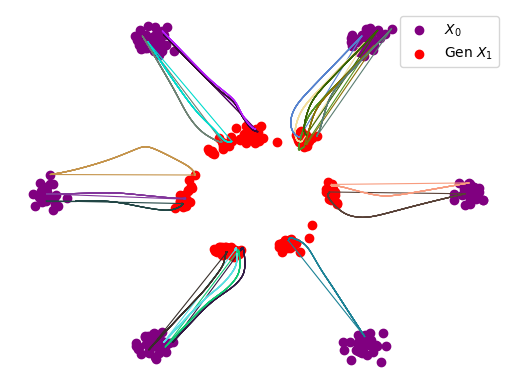

Regular Flow with 1000 steps:


100%|██████████| 1000/1000 [00:13<00:00, 72.74it/s]


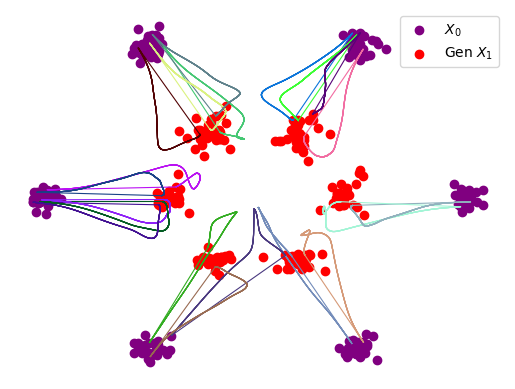

In [14]:
T=1000
print(f"Mean Flow with {T} steps:")
visualize_mean_flow_sampling(mean_flow, T=T)
print(f"Regular Flow with {T} steps:")
visualize_regular_flow_sampling(regular_flow, T=T)

100 steps:

Mean Flow with 100 steps:


100%|██████████| 100/100 [00:01<00:00, 73.89it/s]


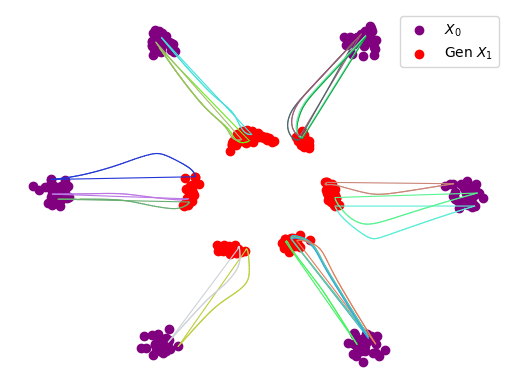

Regular Flow with 100 steps:


100%|██████████| 100/100 [00:01<00:00, 77.24it/s]


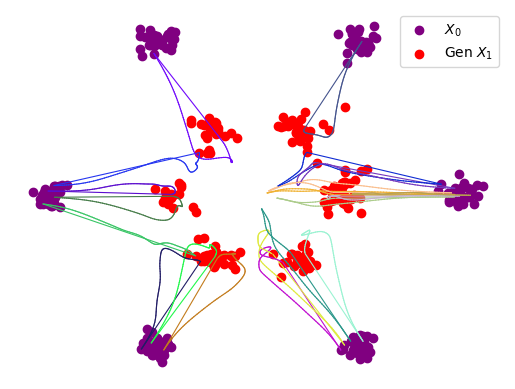

In [31]:
T=100
print(f"Mean Flow with {T} steps:")
visualize_mean_flow_sampling(mean_flow, T=T)
print(f"Regular Flow with {T} steps:")
visualize_regular_flow_sampling(regular_flow, T=T)

10 steps:

Mean Flow with 10 steps:


100%|██████████| 10/10 [00:00<00:00, 91.80it/s]


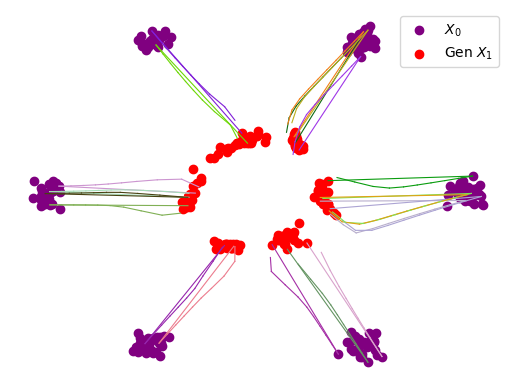

Regular Flow with 10 steps:


100%|██████████| 10/10 [00:00<00:00, 102.96it/s]


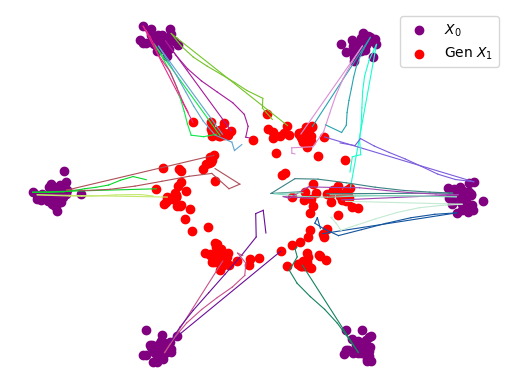

In [16]:
T=10
print(f"Mean Flow with {T} steps:")
visualize_mean_flow_sampling(mean_flow, T=T)
print(f"Regular Flow with {T} steps:")
visualize_regular_flow_sampling(regular_flow, T=T)

1 step:

Mean Flow with 1 step:


100%|██████████| 1/1 [00:00<00:00, 73.14it/s]


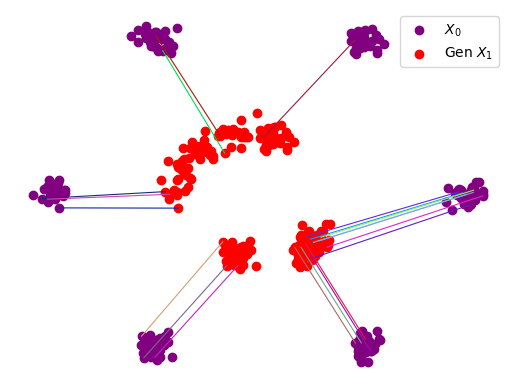

Regular Flow with 1 step:


100%|██████████| 1/1 [00:00<00:00, 84.43it/s]


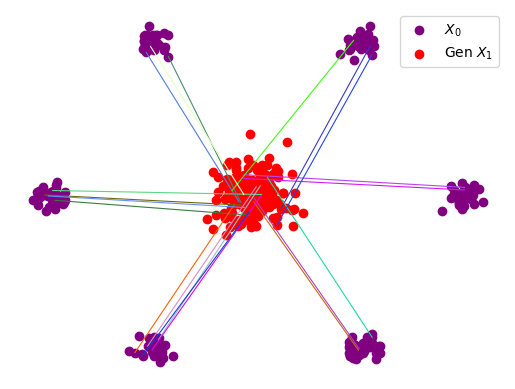

In [30]:
T=1
print(f"Mean Flow with {T} step:")
visualize_mean_flow_sampling(mean_flow, T=T)
print(f"Regular Flow with {T} step:")
visualize_regular_flow_sampling(regular_flow, T=T)

Observations:

- Mean flow trajectories are naturally **straighter** than those of regular flow matching, even with many steps.
  - Note that with infinitely many time steps, the mean velocity is equivalent to the **instantaneous** velocity (referred to as consistency in the paper).
- Mean flow performs worse than the regular flow with enough time steps, but its one-step generation is better.


2000 steps:

Mean Flow with 2000 steps:


100%|██████████| 2000/2000 [00:27<00:00, 73.02it/s]


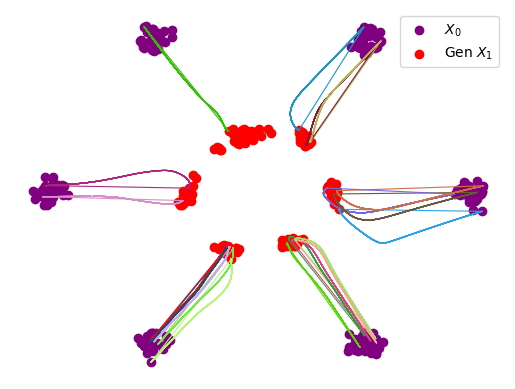

Regular Flow with 2000 steps:


100%|██████████| 2000/2000 [00:27<00:00, 72.93it/s]


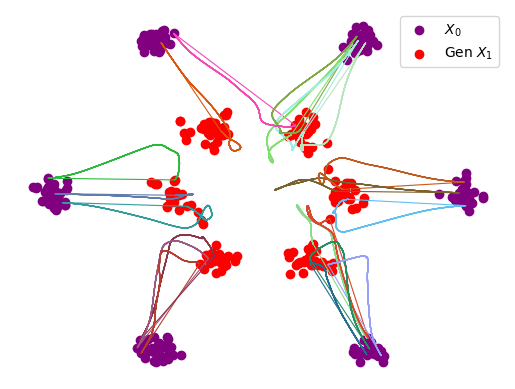

In [18]:
T=2000
print(f"Mean Flow with {T} steps:")
visualize_mean_flow_sampling(mean_flow, T=T)
print(f"Regular Flow with {T} steps:")
visualize_regular_flow_sampling(regular_flow, T=T)